# Language Model Training Pipeline

*Currently only tested for GPT2!* 

#### Imports

In [1]:
import glob
import json
import time
import torch
# import evaluate
import transformers
import numpy as np
import pandas as pd
import evaluate

from sklearn.metrics import top_k_accuracy_score
from pathlib import Path
from tqdm.auto import tqdm
from datasets import Dataset
from tokenizers import Tokenizer
from tokenizers.normalizers import (Sequence, Lowercase, NFD, StripAccents)
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.decoders import BPEDecoder
from transformers import AutoConfig, \
    DataCollatorWithPadding, AutoModelForSequenceClassification, \
    Trainer, TrainingArguments, AutoTokenizer, RobertaConfig
from matplotlib import pyplot as plt

/home/ajain/miniconda3/envs/gpt2/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Config

In [2]:
data_path = Path("/home/ajain/ttmp/PBSCSR_data/")
'''Path to large data folder'''

seed = 42
'''Random seed: int'''

roberta_dir = data_path/"roberta"
roberta_dir.mkdir(exist_ok=True)

train_file = data_path/"LM_pretraining_data/dense_1_8-train.txt"
valid_file = data_path/"LM_pretraining_data/dense_1_8-valid.txt"

pretrained_output = roberta_dir/"pretrained_model"
pretrained_output.mkdir(exist_ok=True, parents=True)

cache_dir = data_path/".cache"
cache_dir.mkdir(exist_ok=True)
'''Path to save cache'''

'Path to save cache'

### Train BPE Tokenizer

In [3]:
vocab_size = 30_000
'''Vocab size for tokenizer: int'''
special_tokens = ["<mask>", "<pad>"]
'''Special tokens for tokenizer: list of strings'''

tokenizer_path = roberta_dir/"tokenizer"/"tokenizer.json"
tokenizer_path.parent.mkdir(exist_ok=True, parents=True)

# Define tokenizer
tokenizer = Tokenizer(BPE())
tokenizer.normalizer = Sequence([NFD(),Lowercase(),StripAccents()])
tokenizer.pre_tokenizer = Whitespace()
tokenizer.decoder = BPEDecoder()
trainer = BpeTrainer(vocab_size=vocab_size, special_tokens=special_tokens)
tokenizer.train([str(train_file)], trainer=trainer) 
tokenizer.save(str(tokenizer_path))

### Language Model Pretraining

*Run the cell below and it will output an LM training shell script in the output model directory you specify. Navigate to that directory and run the shell script in a persistent shell session (TMUX) with the corresponding Python environment*

In [4]:
# Language Model Config
config_class = RobertaConfig
'''Config class for language model: e.g. GPT2Config'''

lm_config = {
    'model_type': 'roberta', # e.g. 'gpt2',
    'vocab_size': 30_000, # e.g. 50257,
    'max_position_embeddings': 1024+2, # e.g. 1024,
    'num_hidden_layers': 6, # e.g. 12,
    # add more config here if needed
}
'''Config for language model: dict
See https://huggingface.co/transformers/model_doc/gpt2.html#gpt2config for an example for GPT2'''

lm_config_str = "\"" + ",".join(f"{k}={v}" for k,v in lm_config.items()) + "\""

# Write out config to tokenizer directory for internal HuggingFace use
with open(str(tokenizer_path.parent/"config.json"), 'w') as fp:
    json.dump(lm_config, fp)


# Create training shell script
cmd = f''' 
torchrun  --nproc_per_node 2
{Path.cwd()/"run_mlm.py"}
--model_type {lm_config["model_type"]}
--tokenizer_name {tokenizer_path.parent.resolve()}
--train_file {train_file.resolve()}
--validation_file {valid_file.resolve()}
--output_dir {pretrained_output.resolve()}
--do_train
--do_eval
--evaluation_strategy steps
--per_device_train_batch_size 4
--per_gpu_eval_batch_size 4
--learning_rate 1e-4
--num_train_epochs 12
--logging_steps 2000
--save_steps 2000
--seed {seed}
--overwrite_output_dir
--local_rank 0
--cache_dir {cache_dir}
--config_overrides="{lm_config_str}"
'''.replace("\n", " ")

# Write out training shell script to output model directory
with open(str(pretrained_output/"train_lm.sh"), "w") as fout:
    fout.write(cmd)

### Language Model Pretraining Curves

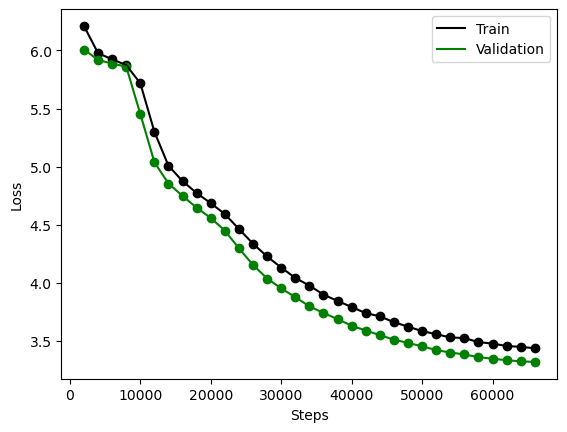

In [3]:
tr_loss = []
val_loss = []
accuracy = []
step = []

with open(pretrained_output/"trainer_state.json", 'r') as f:
    log_history = json.load(f)['log_history']
    for entry in log_history:
        if "loss" in entry:
            step.append(int(entry["step"]))
            tr_loss.append(float(entry["loss"]))
        elif "eval_loss" in entry:
            val_loss.append(float(entry["eval_loss"]))

        if "eval_accuracy" in entry:
            accuracy.append(float(entry["eval_accuracy"]))

step, tr_loss, val_loss, acc = np.array(step), np.array(tr_loss), np.array(val_loss), np.array(accuracy)
plt.plot(step, tr_loss, 'k-', label="Train")
plt.scatter(step, tr_loss, c='k')
plt.plot(step, val_loss, 'g-', label="Validation")
plt.scatter(step, val_loss, c='g')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.show()

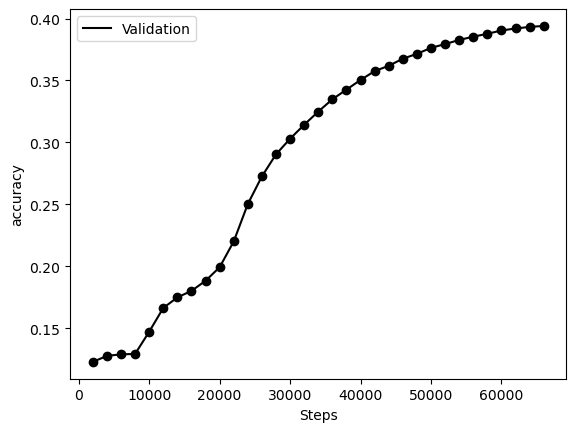

In [4]:

plt.plot(step, acc, 'k-', label="Validation")
plt.scatter(step, acc, c='k')
plt.legend()
plt.xlabel('Steps')
plt.ylabel('accuracy')
plt.show()